# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fbprophet import Prophet


ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('../../data/raw/zillow_data.csv')

In [67]:
df.head(6)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300


In [3]:
def one_zipcode(df, index):
    """This function pulls the data for one zipcode at a time and retuns a DataFrame for using in Prophet."""
    series = df.iloc[index]
    series_data = series.iloc[7:]
    df_series = pd.DataFrame(series_data.values, index = series_data.index, columns = ['y'])
    df_series.index = pd.to_datetime(df_series.index, yearfirst = True, format = '%Y-%m')
    df_series['ds'] = df_series.index
    df_series.reset_index(drop = True, inplace = True)
    df_series['y'] = df_series['y'].astype('int64')
    return df_series

In [64]:
one_zipcode(df, 5)

,y,ds
0,95000,1996-04-01
1,95200,1996-05-01
2,95400,1996-06-01
3,95700,1996-07-01
4,95900,1996-08-01
...,...,...
260,162800,2017-12-01
261,162800,2018-01-01
262,162900,2018-02-01
263,163500,2018-03-01


In [5]:
#Need helper function for zipcode
def get_zipcode(df, index):
    """This function extracts the zipcode from the dataframe at the index. Useful in constructing data dictionanry
    later."""
    zipcode = df['RegionName'].iloc[index]
    return zipcode

In [66]:
get_zipcode(df, 5)

77084

In [3]:
#pull first zip code from df
series_84654 = df.iloc[0]

In [4]:
#drop the meta data for the zip code
df_84654_data = series_84654.iloc[7:]

In [5]:
#take the series that no longer has the first 7 lines, and put it in a DF
df_84654 = pd.DataFrame(df_84654_data.values, index=df_84654_data.index, columns=['y'] )

In [6]:
#set index as date time format
df_84654.index = pd.to_datetime(df_84654.index,yearfirst=True, format='%Y-%m')

In [7]:
df_84654['ds']=df_84654.index

In [8]:
df_84654.reset_index(drop=True, inplace=True)

In [9]:
df_84654['y'] = df_84654['y'].astype('int64')

In [340]:
df_84654.y.dtype

dtype('int64')

In [69]:
def Prophet_analysis(df):
    """This function instantiates a Prophet model, fits it to the DataFrame, and predicts values which are returned in 
    a forecast Dataframe."""
    m = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
    m.fit(df)
    future = m.make_future_dataframe(60, freq = 'M')
    forecast = m.predict(future)
    return forecast

In [70]:
Prophet_analysis(one_zipcode(df, 5))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/brentsair/anaconda3/envs/zipcode/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1996-04-01,94172.959735,90530.649396,97229.988190,94172.959735,94172.959735,-0.001328,-0.001328,-0.001328,-0.001328,-0.001328,-0.001328,0.0,0.0,0.0,94047.911280
1,1996-05-01,94334.401765,90834.243266,97401.503555,94334.401765,94334.401765,-0.002413,-0.002413,-0.002413,-0.002413,-0.002413,-0.002413,0.0,0.0,0.0,94106.736954
2,1996-06-01,94501.225197,90975.874061,97466.888106,94501.225197,94501.225197,-0.002412,-0.002412,-0.002412,-0.002412,-0.002412,-0.002412,0.0,0.0,0.0,94273.284368
3,1996-07-01,94662.667227,91308.417099,97656.583372,94662.667227,94662.667227,-0.002131,-0.002131,-0.002131,-0.002131,-0.002131,-0.002131,0.0,0.0,0.0,94460.908402
4,1996-08-01,94829.490658,91509.364646,97901.122880,94829.490658,94829.490658,-0.001420,-0.001420,-0.001420,-0.001420,-0.001420,-0.001420,0.0,0.0,0.0,94694.795922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,2022-11-30,217399.447796,197810.559785,237434.738864,198024.252237,237655.664418,-0.001377,-0.001377,-0.001377,-0.001377,-0.001377,-0.001377,0.0,0.0,0.0,217100.033548
321,2022-12-31,218273.660615,199165.766814,241686.660233,198566.612018,238994.684496,0.004365,0.004365,0.004365,0.004365,0.004365,0.004365,0.0,0.0,0.0,219226.368046
322,2023-01-31,219147.873434,199508.752520,243238.514384,198965.571492,240408.030892,0.008690,0.008690,0.008690,0.008690,0.008690,0.008690,0.0,0.0,0.0,221052.177743
323,2023-02-28,219937.485013,194370.240287,236842.257682,199278.378117,241581.513915,-0.022566,-0.022566,-0.022566,-0.022566,-0.022566,-0.022566,0.0,0.0,0.0,214974.448614


In [10]:
m = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
m.fit(df_84654)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/brentsair/anaconda3/envs/zipcode/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [11]:
future = m.make_future_dataframe(60, freq='M')
future.tail()

,ds
320,2022-11-30
321,2022-12-31
322,2023-01-31
323,2023-02-28
324,2023-03-31


In [12]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
320,2022-11-30,1.229772e+06,907852.958383,1.603001e+06
321,2022-12-31,1.232032e+06,904744.859529,1.610310e+06
322,2023-01-31,1.235362e+06,907451.153301,1.624012e+06
323,2023-02-28,1.239641e+06,901950.810809,1.640821e+06
324,2023-03-31,1.241099e+06,895194.395285,1.652109e+06


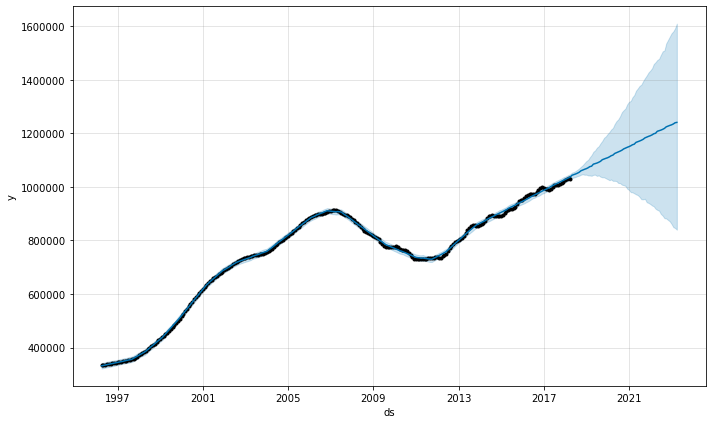

In [344]:
fig1 = m.plot(forecast)

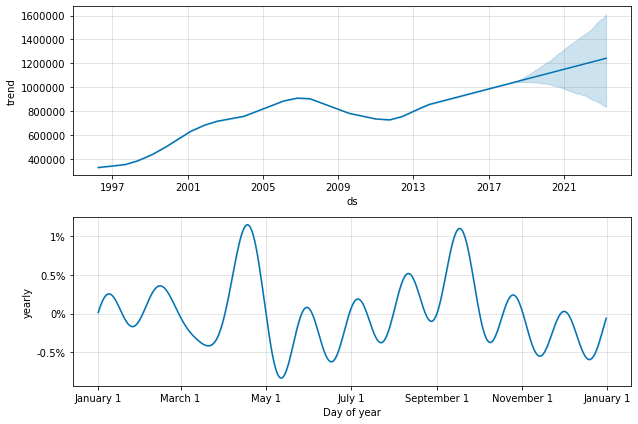

In [345]:
fig2 = m.plot_components(forecast)


In [13]:
df_84654

,y,ds
0,334200,1996-04-01
1,335400,1996-05-01
2,336500,1996-06-01
3,337600,1996-07-01
4,338500,1996-08-01
...,...,...
260,1018700,2017-12-01
261,1024400,2018-01-01
262,1030700,2018-02-01
263,1033800,2018-03-01


In [14]:
def most_recent_value(df):
    '''
    Finds the most recent median home value for use in future percent calculation.
    '''
    i = -1
    while np.isnan(df.iloc[i]['y']):
        i -= 1

    return df.iloc[i]['y']

In [71]:
def combine_dataframes(df, forecast):
    """This function combines the original dataframe with data from one zipcode and the forecasted values from the
    Prophet analysis into a single DataFrame. It also adds new columns for percent change from the last value in
    the original dataframe and the estimated gross profit."""
    forecast.rename(columns={'yhat': 'y'}, inplace = True)
    forecast_subset = forecast[forecast['ds']>'2018-04-01'][['ds','y', 'yhat_lower', 'yhat_upper']]
    df_appended = df.append(forecast_subset, sort = True)
    df_appended['pct_change'] = ((df_appended['y']-most_recent_value(df))/most_recent_value(df))*100
    df_appended['gross_profit'] = (df_appended['y']-most_recent_value(df))
    return df_appended

In [73]:
combine_dataframes(one_zipcode(df, 5), Prophet_analysis(one_zipcode(df, 5)))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,y,yhat_lower,yhat_upper,pct_change,gross_profit
0,1996-04-01,95000.000000,NaN,NaN,-42.178941,-69300.000000
1,1996-05-01,95200.000000,NaN,NaN,-42.057212,-69100.000000
2,1996-06-01,95400.000000,NaN,NaN,-41.935484,-68900.000000
3,1996-07-01,95700.000000,NaN,NaN,-41.752891,-68600.000000
4,1996-08-01,95900.000000,NaN,NaN,-41.631163,-68400.000000
...,...,...,...,...,...,...
320,2022-11-30,217100.033548,194246.752928,236436.935032,32.136356,52800.033548
321,2022-12-31,219226.368046,196208.297520,239454.159068,33.430534,54926.368046
322,2023-01-31,221052.177743,196810.869177,242875.529022,34.541800,56752.177743
323,2023-02-28,214974.448614,190900.391650,235204.132102,30.842635,50674.448614


In [15]:
forecast.rename(columns={"yhat": "y"}, inplace = True)

In [16]:
forecast_subset = forecast[forecast['ds']>'2018-04-01'][['ds','y']]

In [17]:
df_84654_appended = df_84654.append(forecast_subset)

/Users/brentsair/anaconda3/envs/zipcode/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [18]:
df_84654_appended['pct_change'] = ((df_84654_appended['y']-most_recent_value(df_84654))/most_recent_value(df_84654))*100


In [19]:
df_84654_appended['net_profit'] = (df_84654_appended['y']-most_recent_value(df_84654))


In [20]:
df_84654_appended

,ds,y,pct_change,net_profit
0,1996-04-01,3.342000e+05,-67.572288,-696400.000000
1,1996-05-01,3.354000e+05,-67.455851,-695200.000000
2,1996-06-01,3.365000e+05,-67.349117,-694100.000000
3,1996-07-01,3.376000e+05,-67.242383,-693000.000000
4,1996-08-01,3.385000e+05,-67.155055,-692100.000000
...,...,...,...,...
320,2022-11-30,1.229772e+06,19.325783,199171.521998
321,2022-12-31,1.232032e+06,19.545088,201431.673382
322,2023-01-31,1.235362e+06,19.868234,204762.020062
323,2023-02-28,1.239641e+06,20.283383,209040.545011


In [76]:
def make_dict(df, zipcode):
    """This function returns a summary dictionary from the combined dataframe for a given zipcode. This dictionary
    can be appended to a list that will be used to make a final dataframe."""
    pct_change_1year = df.loc[(df['ds']>'2019-03-31') 
                                       & (df['ds']<'2019-05-01')]['pct_change'].values[0]
    gross_profit_1year = df.loc[(df['ds']>'2019-03-31') 
                                       & (df['ds']<'2019-05-01')]['gross_profit'].values[0]
    pct_change_5year = df.loc[(df['ds']>='2023-03-31')]['pct_change'].values[0]
    gross_profit_5year = df.loc[(df['ds']>='2023-03-31')]['gross_profit'].values[0]
    estimate_1year = df.loc[(df['ds']>'2019-03-31') 
                                       & (df['ds']<'2019-05-01')]['y'].values[0]
    upper_1year = df.loc[(df['ds']>'2019-03-31') 
                                       & (df['ds']<'2019-05-01')]['yhat_upper'].values[0]
    lower_1year = df.loc[(df['ds']>'2019-03-31') 
                                       & (df['ds']<'2019-05-01')]['yhat_lower'].values[0]
    estimate_5year = df.loc[(df['ds']>='2023-03-31')]['y'].values[0]
    upper_5year = df.loc[(df['ds']>='2023-03-31')]['yhat_upper'].values[0]
    lower_5year = df.loc[(df['ds']>='2023-03-31')]['yhat_lower'].values[0]
    zipcode_dict = {'Zipcode': zipcode, 
                    'estimate_1year': estimate_1year,
                    'upper_1year': upper_1year,
                    'lower_1year': lower_1year,
                    'pct_change_1year': pct_change_1year,
                    'estimate_5year': estimate_5year,
                    'upper_5year': upper_5year,
                    'lower_5year': lower_5year,
                    'gross_profit_1year': gross_profit_1year, 
                    'pct_change_5year': pct_change_5year, 
                    'gross_profit_5year': gross_profit_5year}
    return zipcode_dict

In [75]:
make_dict(combine_dataframes(one_zipcode(df, 5), Prophet_analysis(one_zipcode(df, 5))), get_zipcode(df, 5))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/brentsair/anaconda3/envs/zipcode/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


{'Zipcode': 77084,
 'estimate_1year': 181572.40107684967,
 'upper_1year': 185528.7818539073,
 'lower_1year': 178073.86034418625,
 'pct_change_1year': 10.512721288405153,
 'estimate_5year': 218860.52835195255,
 'upper_5year': 238487.31727109101,
 'lower_5year': 196307.92387066188,
 'gross_profit_1year': 17272.401076849666,
 'pct_change_5year': 33.20786874738439,
 'gross_profit_5year': 54560.528351952555}

In [61]:
dict1 = [{'Zipcode': series_84654['RegionName'], 
 'pct_change_1year': pct_change_1year, 
 'net_profit_1year': net_profit_1year, 
 'pct_change_5year': pct_change_5year, 
 'net_profit_5year': net_profit_5year},
         {'Zipcode': series_84654['RegionName'], 
 'pct_change_1year': pct_change_1year, 
 'net_profit_1year': net_profit_1year, 
 'pct_change_5year': pct_change_5year, 
 'net_profit_5year': net_profit_5year}]

In [62]:
pd.DataFrame.from_dict(dict1)

,Zipcode,pct_change_1year,net_profit_1year,pct_change_5year,net_profit_5year
0,60657,5.279582,54411.372993,20.424874,210498.753397
1,60657,5.279582,54411.372993,20.424874,210498.753397


In [39]:
df_84654_appended.iloc[df_84654_appended[(df_84654_appended['ds']>'2019-03-31') 
                                         & (df_84654_appended['ds']<'2019-05-01')].index]['pct_change'].iloc[0]

5.2795820874422725

In [46]:
pct_change_1year = df_84654_appended.loc[(df_84654_appended['ds']>'2019-03-31') 
                                       & (df_84654_appended['ds']<'2019-05-01')]['pct_change'].values[0]

In [47]:
net_profit_1year = df_84654_appended.loc[(df_84654_appended['ds']>'2019-03-31') 
                                       & (df_84654_appended['ds']<'2019-05-01')]['net_profit'].values[0]

In [49]:
pct_change_5year = df_84654_appended.loc[(df_84654_appended['ds']>='2023-03-31') 
                                       ]['pct_change'].values[0]

In [50]:
net_profit_5year = df_84654_appended.loc[(df_84654_appended['ds']>='2023-03-31') 
                                       ]['net_profit'].values[0]

In [37]:
temp.iloc[0]

5.2795820874422725

In [384]:
one_year_df = pd.DataFrame(columns=['RegionID','RegionName','City','State','Metro','CountyName','y','pct_change','net_profit'])

In [387]:
ind_row = pd.DataFrame(df_84654_appended[(df_84654_appended['ds']>'2019-03-31') & (df_84654_appended['ds']<'2019-05-01') ][['y','pct_change','net_profit']])
    

,y,pct_change,net_profit
277,1.085011e+06,5.279582,54411.372993


In [396]:
one_year_df = one_year_df.append(df_84654_appended[(df_84654_appended['ds']>'2019-03-31') & (df_84654_appended['ds']<'2019-05-01') ][['y','pct_change','net_profit']]
    )

/Users/brentsair/anaconda3/envs/zipcode/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [397]:
one_year_df

,City,CountyName,Metro,RegionID,RegionName,State,net_profit,pct_change,y
277,NaN,NaN,NaN,NaN,NaN,NaN,54411.372993,5.279582,1.085011e+06


In [405]:
one_year_df.join(pd.DataFrame(series_84654), how='left')

,City,CountyName,Metro,RegionID,RegionName,State,net_profit,pct_change,y,0
277,NaN,NaN,NaN,NaN,NaN,NaN,54411.372993,5.279582,1.085011e+06,NaN


In [406]:
one_year_df

,City,CountyName,Metro,RegionID,RegionName,State,net_profit,pct_change,y
277,NaN,NaN,NaN,NaN,NaN,NaN,54411.372993,5.279582,1.085011e+06


In [392]:
series_84654[:7]

RegionID        84654
RegionName      60657
City          Chicago
State              IL
Metro         Chicago
CountyName       Cook
SizeRank            1
Name: 0, dtype: object

# Step 2: Data Preprocessing

In [151]:
df_84654

KeyError: '2018'

In [ ]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

# Step 3: EDA and Visualization

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

# Step 4: Reshape from Wide to Long Format

In [ ]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

# Step 5: ARIMA Modeling

# Step 6: Interpreting Results

In [7]:
ex_ts = one_zipcode(df, 23)

In [6]:
get_zipcode(df, 23)

77584

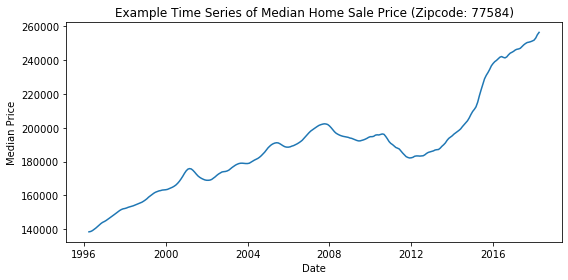

In [15]:
fig = plt.figure(figsize = (8, 4))
plt.plot(ex_ts['ds'], ex_ts['y'])
plt.title(f"Example Time Series of Median Home Sale Price (Zipcode: {get_zipcode(df, 23)})")
plt.xlabel("Date")
plt.ylabel("Median Price")
plt.tight_layout()
plt.savefig("Example_time_series.png", dpi = 200);